In [1]:
%pip install -Uq bertopic kaleido adjustText>=1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
docs_df = pd.read_csv("pubs.csv", index_col=0)
docs_df["doc"] = docs_df["title"] + ":\n\n\n" + docs_df["abstract"]

In [4]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=6, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=2)
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(seed_words=["polarization", "framing", "behavior"])
topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model)

In [5]:
topics, probs = topic_model.fit_transform(docs_df["doc"])
topics, probs

([1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1],
 array([1.        , 0.74316022, 0.62349862, 0.83318647, 0.82888562,
        1.        , 0.44060213, 1.        , 1.        , 1.        ,
        0.52556706, 1.        , 1.        , 0.89831574, 1.        ,
        0.65400166]))

In [6]:
topic_df = topic_model.get_topic_info()
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,7,0_framing_analysis_frame_frames,"[framing, analysis, frame, frames, content, me...",[Computational Narrative Framing: Towards Iden...
1,1,6,1_polarization_social_survey_data,"[polarization, social, survey, data, measures,...",[Combining Survey and Social Media Data: Respo...
2,2,3,2_behavior_music_act_tracks,"[behavior, music, act, tracks, memory, user, r...",[Integrating the ACT-R framework with collabor...


In [7]:
topic_df["Representation"].tolist()

[['framing',
  'analysis',
  'frame',
  'frames',
  'content',
  'media',
  'news',
  'detection',
  'narrative',
  'using'],
 ['polarization',
  'social',
  'survey',
  'data',
  'measures',
  'media',
  'opinions',
  'covid',
  'twitter',
  '19'],
 ['behavior',
  'music',
  'act',
  'tracks',
  'memory',
  'user',
  'relistening',
  'human',
  'models',
  'model']]

In [8]:
# Represenative docs per cluster
r1 = docs_df[docs_df["doc"].isin(topic_df["Representative_Docs"].tolist()[0])].index.tolist()
r2 = docs_df[docs_df["doc"].isin(topic_df["Representative_Docs"].tolist()[1])].index.tolist()
r3 = docs_df[docs_df["doc"].isin(topic_df["Representative_Docs"].tolist()[2])].index.tolist()
rdocs = r1+r2+r3
r1, r2, r3

(['C2 Exploration', 'C5 Structure', 'C8 Narrative'],
 ['C1 Polarization', 'S7 Willingness', 'S8 Role'],
 ['S1 Relistening', 'S4 Humanize', 'S5 ACT-R+CF'])

In [9]:
embs = topic_model.embedding_model.embed(docs_df["doc"])
reduced = topic_model.umap_model.fit_transform(embs)
embs.shape, "=>", reduced.shape

((16, 384), '=>', (16, 2))

In [10]:
labels = topic_model.hdbscan_model.fit(reduced).labels_
labels

array([2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 2])

In [11]:
def choose_marker(index):
    if index in rdocs:
        return "s"
    return "o"
markers = list(map(choose_marker, docs_df.index))
marker_map  = {"s": "s", "o": "o"}

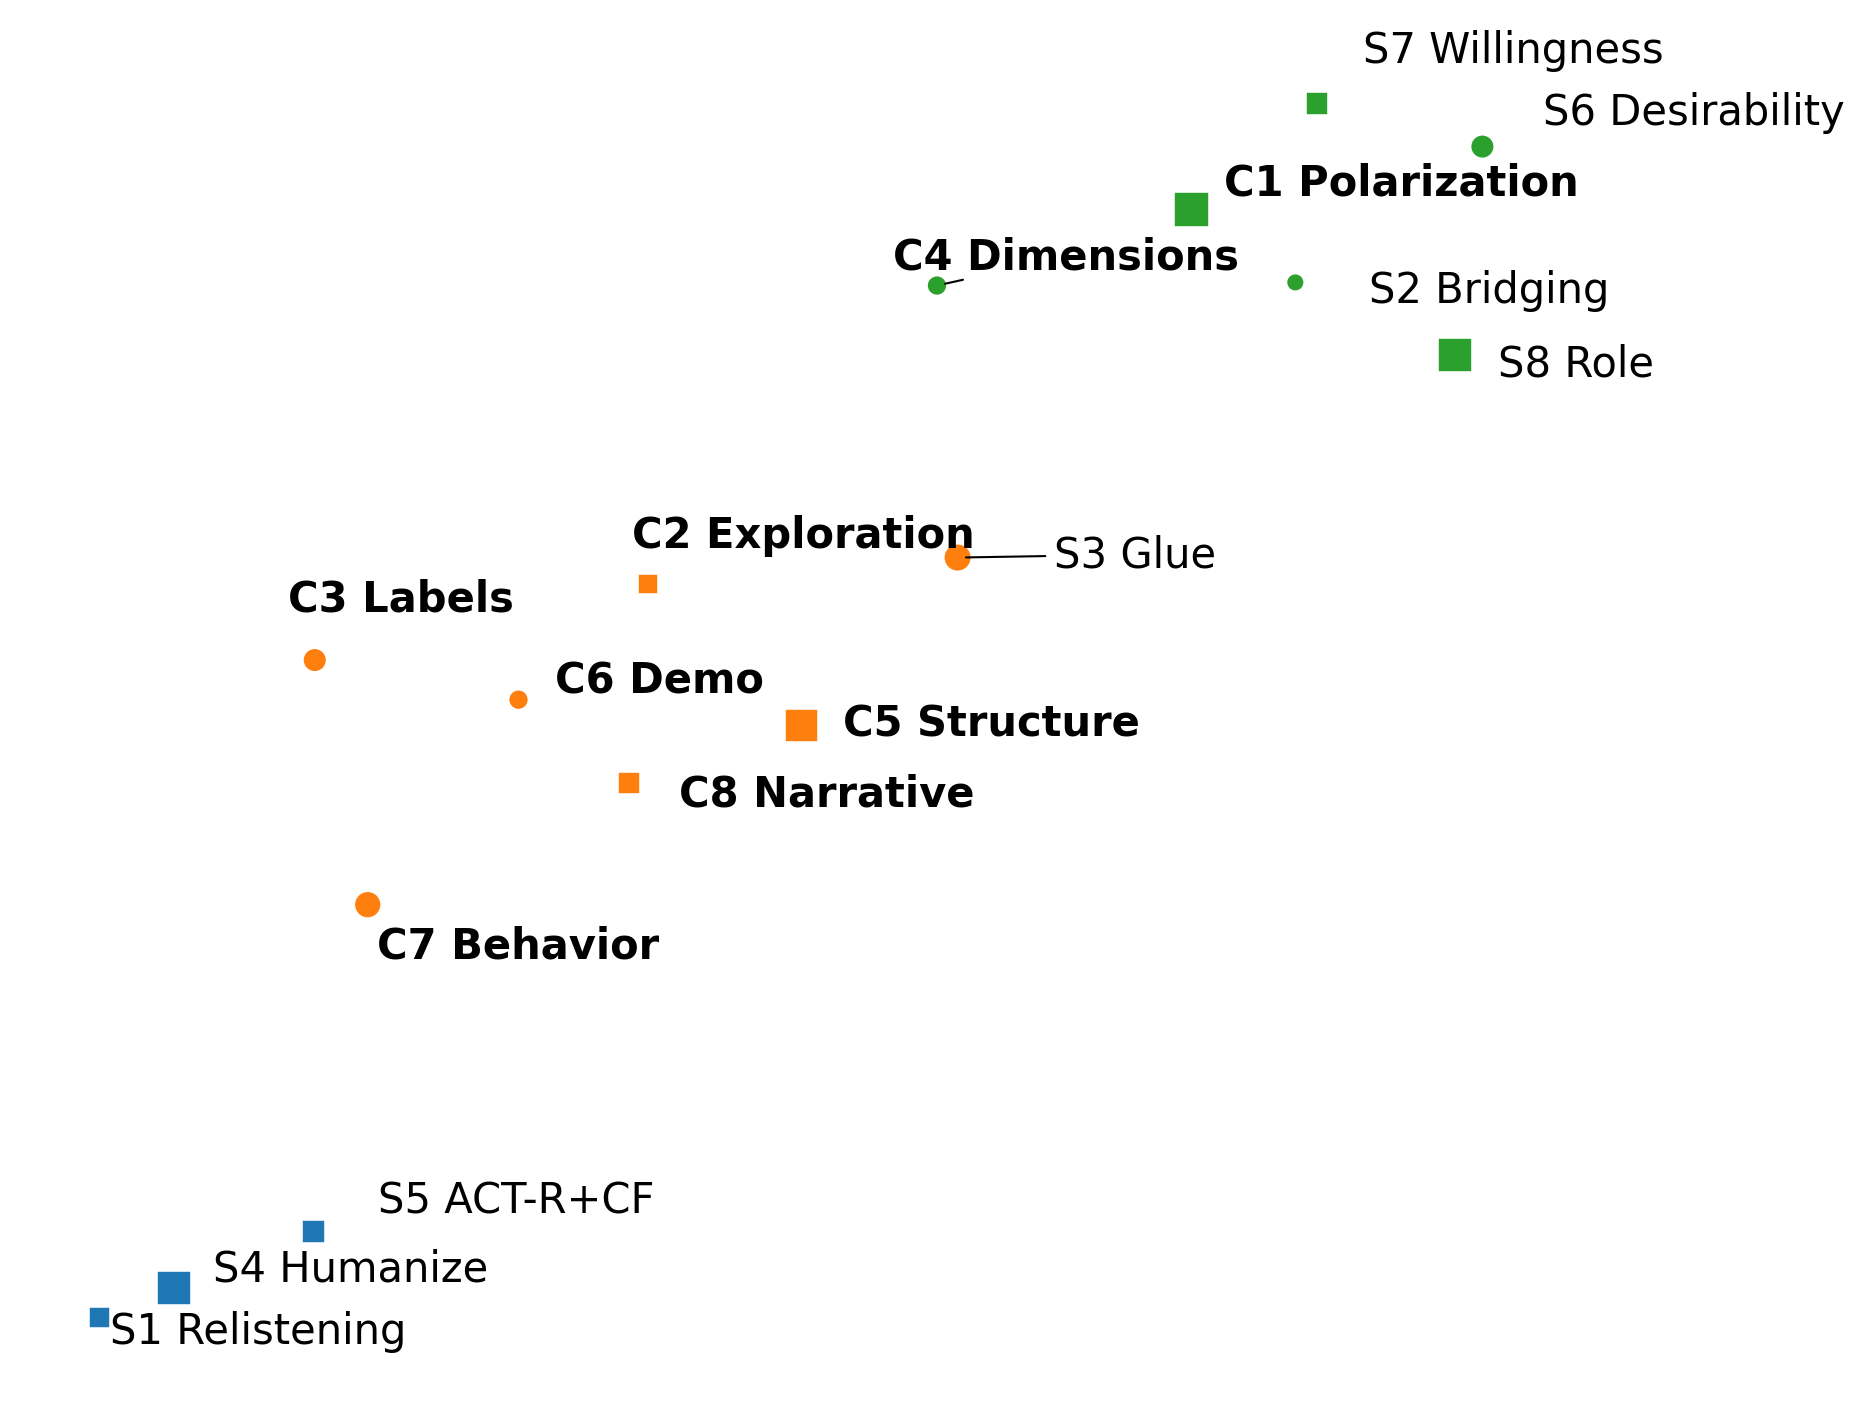

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette=sns.color_palette(), style=markers, markers=marker_map, size=docs_df["pages"]) 
texts = []
for i, key in enumerate(docs_df.index):
    if key.startswith("C"):
        t = ax.annotate(key, (reduced[i, 0], reduced[i, 1]), weight="bold")
    else:
        t = ax.annotate(key, (reduced[i, 0], reduced[i, 1]))
    texts.append(t)
plt.axis("off")
ax.get_legend().remove()
adjust_text(texts, force_text=(0.1, 0.2), force_static=(0, 0), ensure_inside_axes=False, expand_axes=True,
            force_pull=(0, 0), min_arrow_len=50, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
plt.tight_layout()
plt.savefig('bertopic_pubs.pdf')
plt.show()